In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from narx import NARX_4

data = pd.read_parquet('Data/pump_station_data.parquet')
data = data[:]["2023-02-14":"2023-02-16"]
data_10s = data["2023-02-14 05:00:00 ":"2023-02-14 17:00:00"].resample("10s").mean()
# fig, ax = plt.subplots(2)
# ax[0].plot(data['outflow'])
# ax[1].plot(data['height'])
# fig.show
# fig, ax = plt.subplots(2)
# ax[0].plot(data['pump1_rpm'])
# ax[1].plot(data['pump1_power'])
# fig.show

# Building a static model of the 


In [7]:
import sklearn.model_selection as modsel

data_train, data_test = modsel.train_test_split(data_10s, test_size=0.2, shuffle=False)


In [8]:
# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_train = data_train.drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)
x_train = x_train.to_numpy()
y_train = data_train['outflow'].values.reshape(-1,1)
print(type(y_train))

x_test = data_test[180:].drop(labels=['height','outflow', 'pump1_rpm', 'pump4_rpm'], axis=1)

x_test = x_test.to_numpy()
y_test = data_test[180:]['outflow'].values.reshape(-1,1)
print(x_train.size)

<class 'numpy.ndarray'>
6912


In [9]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error, mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [10]:

# The model is fitted 
basis_function= Polynomial(degree=1)

model = FROLS(
    order_selection=True,
    n_terms = 6,
    extended_least_squares=False,
    ylag=1,
    xlag=[[1, 17],[1,17]],
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
    )
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_test,y=y_test, forecast_horizon=400)
rrse = root_relative_squared_error(y_test, yhat)


/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
/home/martin/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:569: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 6
  self.info_values = self.information_criterion(reg_matrix, y)


In [11]:
mse = mean_squared_error(y_test, yhat)
print(mse)
print(rrse)

155.67390499952975
0.4013975790898836


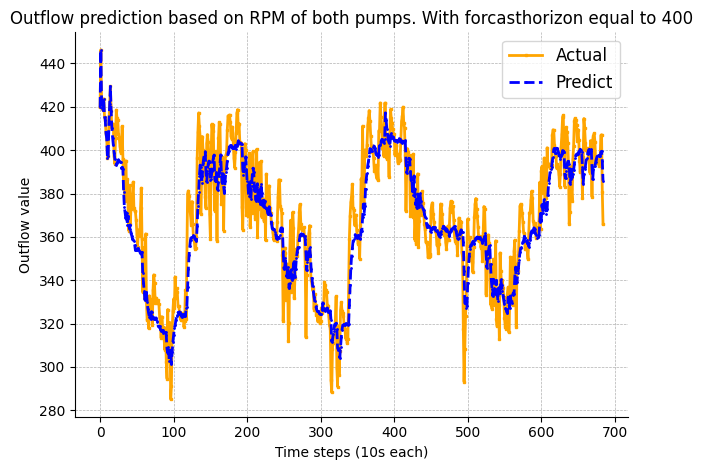

In [12]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(y_test, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(yhat, color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')


ax.set_title(f"Outflow prediction based on RPM of both pumps. With forcasthorizon equal to 400")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()

plt.show()
#plt.savefig()

plt.show()

In [13]:
r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)
r.to_csv("arx_model.csv")

  Regressors   Parameters             ERR
0     y(k-1)   6.9869E-01  9.97571876E-01
1          1  -7.5574E+01  7.86804541E-05
2   x1(k-17)   3.3937E-01  8.31258704E-06
3   x2(k-17)   2.8172E-01  2.30901900E-05
4    x2(k-1)   4.4300E+00  1.20778951E-05
5    x1(k-1)   3.8477E+00  2.08884337E-04


155.67390499952975


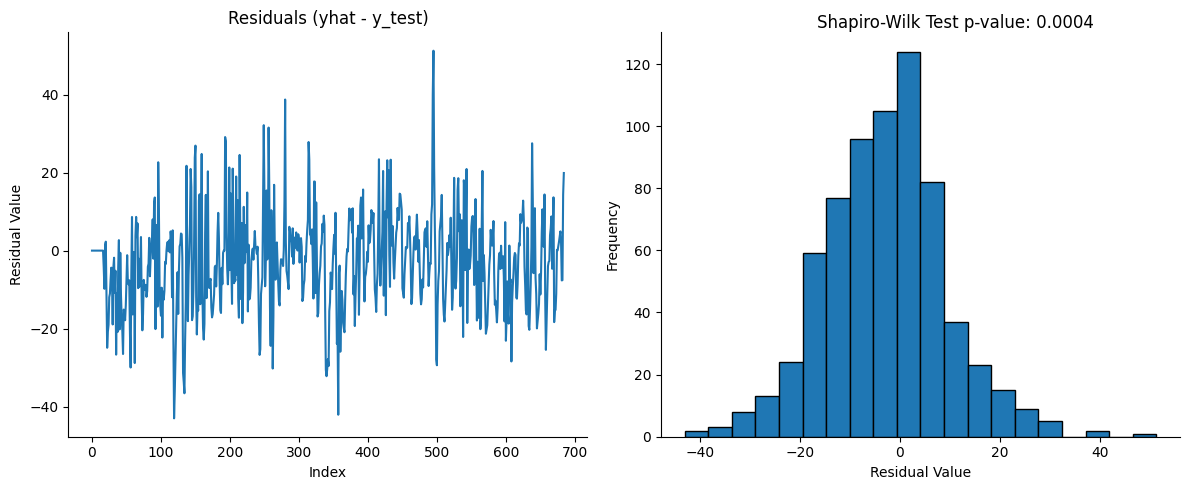

Shapiro-Wilk Test result:
Statistic: 0.9912, p-value: 0.0004


In [14]:
from scipy.stats import shapiro
residuals = yhat - y_test

mse = np.mean(residuals**2)
print(mse)
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [15]:
from sklearn.linear_model import BayesianRidge
from sysidentpy.general_estimators import NARX
from sysidentpy.basis_function._basis_function import Polynomial
basis_function= Polynomial(degree=1)
rrse_low = 1
i_j_a_best = []
yhat_best = []

BayesianRidge_narx = NARX(
base_estimator=BayesianRidge(),
xlag=[[1, 14],[1,14],[1,14]],
ylag=3,
basis_function=basis_function,
model_type="NARMAX",
)

BayesianRidge_narx.fit(X=x_train, y=y_train)
yhat = BayesianRidge_narx.predict(X=x_test,y=y_test, forecast_horizon=400)
rrse_narx= root_relative_squared_error(y_test, yhat)
print(rrse_narx)
                                

                




0.4134804598173273


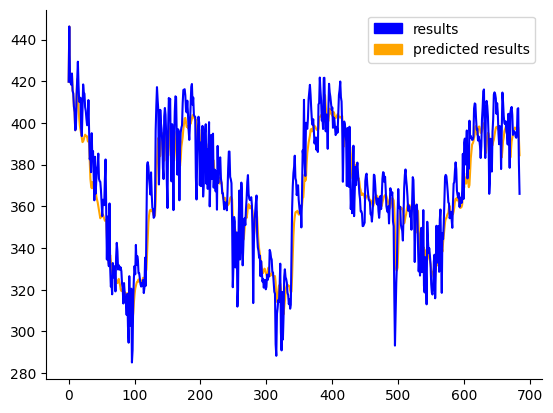

In [16]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat, color='orange')
ax.plot(y_test, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()


685


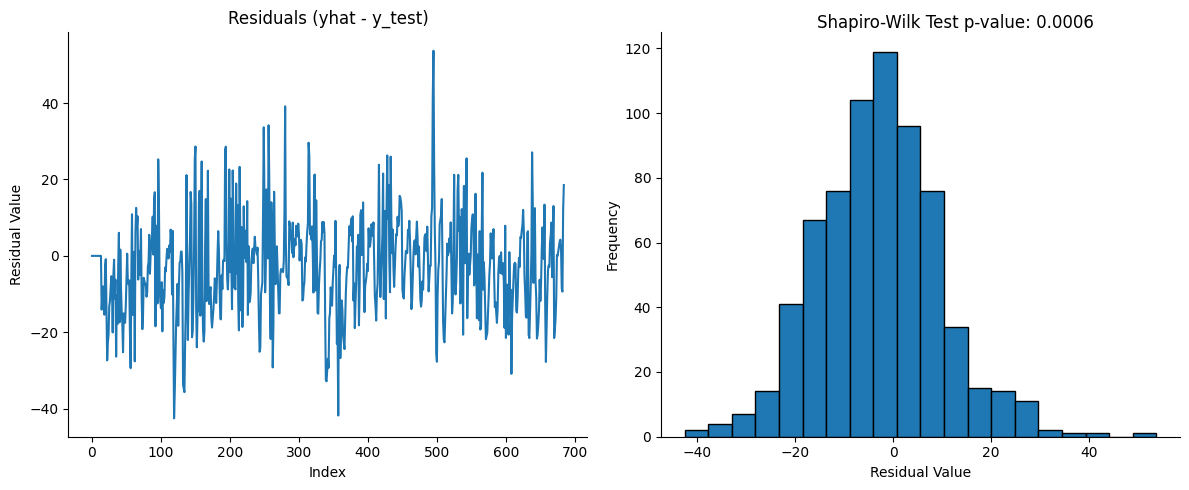

Shapiro-Wilk Test result:
Statistic: 0.9915, p-value: 0.0006


In [17]:
from scipy.stats import shapiro
residuals = yhat - y_test
#print(yhat)
#print(y_test_compare_4)
#print(yhat.squeeze())


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
print(residuals.size)
# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [18]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

torch.manual_seed(0)

Using cuda device


In [19]:
# basis_function = Polynomial(degree=1)
# rrse_low = 1
# yhat_best = []

# narx_net = NARXNN(
#         ylag=2,
#         xlag=[[5], [5]],
#         basis_function=basis_function,
#         model_type="NARMAX",
#         loss_func="mse_loss",
#         optimizer="Adam",
#         epochs=100,
#         learning_rate = 4e-3,
#         verbose=False,
#         device='cuda',
#         optim_params={
#             "betas": (0.9, 0.999),
#             "eps": 1e-05,
#         }, 
#     )
# class NARX(nn.Module):
#         def __init__(self):
#             super().__init__()
#             self.lin = nn.Linear(4, 30)
#             self.lin2 = nn.Linear(30, 30)
#             self.lin3 = nn.Linear(30, 1)
#             self.tanh = nn.Tanh()

#         def forward(self, xb):
#             z = self.lin(xb)
#             z = self.tanh(z)
#             z = self.lin2(z)
#             z = self.tanh(z)
#             z = self.lin3(z)
#             return z
# narx_net.net = NARX()
# if device == "cuda": 
#     narx_net.net.to(torch.device("cuda"))
# narx_net.fit(X=x_train, y=y_train,X_test=x_test, y_test=y_test)
# yhat_best = narx_net.predict(X=x_test, y=y_test)
# print("MSE: ", mean_squared_error(y_test, yhat))
# rrse = root_relative_squared_error(y_, yhat)
# print("RRSE: ",rrse)
    
   
                                


In [20]:
# print("MSE: ", mean_squared_error(y_test, yhat_best))
# rrse = root_relative_squared_error(y_test, yhat_best)
# print("RRSE: ",rrse)
    


In [21]:
""" 
import matplotlib.patches as mpatches
fig, ax = plt.subplots()
ax.plot(yhat_best, color='orange')
ax.plot(y_test, color='blue')
orange_patch = mpatches.Patch(color='orange', label='predicted results')
blue_patch = mpatches.Patch(color='blue', label='results')
ax.legend(handles=[blue_patch,orange_patch])

plt.show()
 """

" \nimport matplotlib.patches as mpatches\nfig, ax = plt.subplots()\nax.plot(yhat_best, color='orange')\nax.plot(y_test, color='blue')\norange_patch = mpatches.Patch(color='orange', label='predicted results')\nblue_patch = mpatches.Patch(color='blue', label='results')\nax.legend(handles=[blue_patch,orange_patch])\n\nplt.show()\n "

In [22]:
import sklearn.model_selection as modsel    
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_data = data['2023-02-14 12:27:00':'2023-02-14 14:50:00'].resample("10s").mean()


train_data = train_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump4_rpm'], axis=1)
train_data = train_data.reset_index(drop=True)

scaled_data = scaler.fit_transform(train_data)

train_data = pd.DataFrame(scaled_data,columns=train_data.columns, index=train_data.index)
data_train, data_test = modsel.train_test_split(train_data, test_size=0.2, shuffle=False)

x_train_1 = data_train['pump1_rpm'].values.reshape(-1,1)


y_train_1 = data_train['outflow'].values.reshape(-1,1)

# Format the data so that it can be used to fit the ARX model
# The rpm values of both pumps are chosen as input values
x_test_1 = data_test['pump1_rpm'].values.reshape(-1,1)
y_test_1 = data_test['outflow'].values.reshape(-1,1)

compare_1_data = data['2023-02-15 13:27:00':'2023-02-15 15:50:00'].resample("10s").mean()
x_compare_1 = compare_1_data['pump1_rpm'].values.reshape(-1,1)
y_compare_1 = compare_1_data['outflow'].values.reshape(-1,1)


In [23]:
train_data.index

RangeIndex(start=0, stop=859, step=1)

In [24]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

Using cuda device


In [25]:
basis_function = Polynomial(degree=1)
eval_dict={}
rrse_low = 1
i_best = 0
yhat_best = []
for i in ['RReLU']:
    narx_net = NARXNN(
            ylag=2,
            xlag= 3,
            basis_function=basis_function,
            model_type="NARMAX",
            loss_func="mse_loss",
            optimizer="Adam",
            epochs=2000,
            device='cuda',
            learning_rate = 4e-3,
            verbose=False,
            optim_params={
                "betas": (0.9, 0.999),
                "eps": 1e-05,
            }, 
        )
    class NARX(nn.Module):
                def __init__(self):
                    super().__init__()
                    self.lin = nn.Linear(5, 30)
                    self.lin2 = nn.Linear(30, 64)
                    self.lin3 = nn.Linear(64, 64)
                    self.lin4 = nn.Linear(64, 30)               
                    self.lin5 = nn.Linear(30, 1)
                    self.tanh = eval("nn."+i+"()")
                    

                def forward(self, xb):
                    z = self.lin(xb)
                    z = self.tanh(z)
                    z = self.lin2(z)
                    z = self.tanh(z)
                    z = self.lin3(z)
                    z = self.tanh(z)
                    z = self.lin4(z)
                    z = self.tanh(z)
                    z = self.lin5(z)
                    z = self.tanh(z)
                    
                    return z
    narx_net.net = NARX()
    if device == "cuda": 
        narx_net.net.to(torch.device("cuda"))
    narx_net.fit(X=x_train_1, y=y_train_1,X_test=x_test_1, y_test=y_test_1)
    yhat = narx_net.predict(X=x_compare_1, y=y_compare_1)
    # mse = mean_squared_error(y_test_1, yhat)
    # print("MSE: ", mse)
    #rrse = root_relative_squared_error(y_compare_1, yhat)
    #print("RRSE: ",rrse)   
    #eval_dict.update({i:{"mse":mse,'yhat':yhat}})

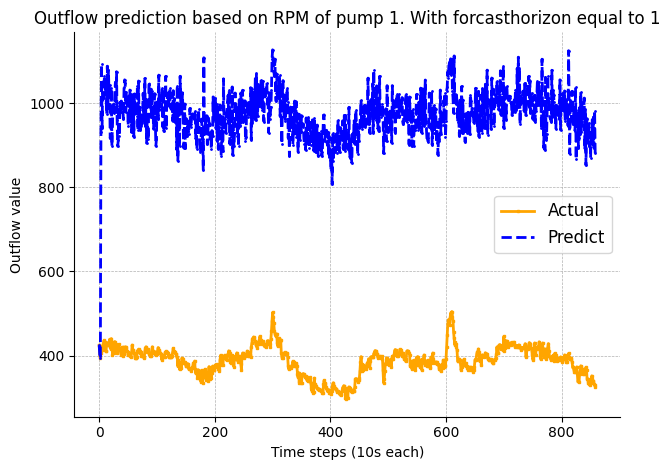

In [26]:
fig, ax = plt.subplots()
ax.plot(y_compare_1, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(yhat ,color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')

ax.set_title(f"Outflow prediction based on RPM of pump 1. With forcasthorizon equal to 1")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()

plt.show()
#plt.savefig()

In [27]:
'''from scipy.stats import shapiro


residuals = yhat - y_test_1
#print(yhat)
#print(y_test_compare_4)
#print(yhat.squeeze())


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
print(residuals.size)
# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")'''

'from scipy.stats import shapiro\n\n\nresiduals = yhat - y_test_1\n#print(yhat)\n#print(y_test_compare_4)\n#print(yhat.squeeze())\n\n\n# Create a figure and a set of subplots\nfig, axs = plt.subplots(1, 2, figsize=(12, 5))\n\n# First subplot: Plot of residuals\naxs[0].plot(residuals)\naxs[0].set_title(\'Residuals (yhat - y_test)\')\naxs[0].set_xlabel(\'Index\')\naxs[0].set_ylabel(\'Residual Value\')\n\n# Second subplot: Histogram of residuals\naxs[1].hist(residuals, bins=20, edgecolor=\'black\')\naxs[1].set_xlabel(\'Residual Value\')\naxs[1].set_ylabel(\'Frequency\')\nprint(residuals.size)\n# Perform Shapiro-Wilk Test for normality\nstat, p = shapiro(residuals)\naxs[1].annotate(f\'Shapiro-Wilk Test p-value: {p:.4f}\', xy=(0.3, 1.01), xycoords=\'axes fraction\', fontsize=12)\n\nplt.tight_layout()\nplt.show()\n\n# Print Shapiro-Wilk Test result\nprint("Shapiro-Wilk Test result:")\nprint(f"Statistic: {stat:.4f}, p-value: {p:.4f}")'

In [28]:
alpha = 0.05  # significance level
if p > alpha:
    print("The Shapiro-Wilk test is successful: the data follows a normal distribution.")
else:
    print("The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.")

The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.


In [29]:
import sklearn.model_selection as modsel    
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Get a data sample from the dataset in which pump 4 is running and resample 
# it to reduce the training time of the model

train_data = data['2023-02-14 10:00:00':'2023-02-14 11:20:00'].resample("10s").mean()


train_data = train_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump1_rpm'], axis=1)
train_data = train_data.reset_index(drop=True)
scaled_data = scaler.fit_transform(train_data)


# Split the data into train and test data for the model training
train_data = pd.DataFrame(scaled_data,columns=train_data.columns, index=train_data.index)
data_train, data_test = modsel.train_test_split(train_data, test_size=0.2, shuffle=False)

# Format the data so that it can be used for training the model
x_train_4 = data_train['pump4_rpm'].values.reshape(-1,1)
y_train_4 = data_train['outflow'].values.reshape(-1,1)


# Format the data so that it can be used to fit the neural network
x_test_4 = data_test['pump4_rpm'].values.reshape(-1,1)
y_test_4 = data_test['outflow'].values.reshape(-1,1)

# Get test data for the model comparison after training 
# This data is taken just after the data used for training
test_data = data['2023-02-14 11:20:00':'2023-02-14 12:20:00'].resample("10s").mean()
test_data = test_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump1_rpm'], axis=1)
test_data = test_data.reset_index(drop=True)
scaled_test_data = scaler.fit_transform(test_data)
test_data = pd.DataFrame(scaled_test_data,columns=test_data.columns, index=test_data.index)

#Format the data so that it can be used with the toolbox
x_test_compare_4 = test_data['pump4_rpm'].values.reshape(-1,1)
y_test_compare_4 = test_data['outflow'].values.reshape(-1,1)

# Get compare data from a day later to validate the model
compare_data = data['2023-02-15 11:00:00':'2023-02-15 13:00:00'].resample("10s").mean()

compare_data = compare_data.drop(labels=['height', 'pump1_power','pump4_power', 'pump1_rpm'], axis=1)
compare_data = compare_data.reset_index(drop=True)
scaled_compare_data = scaler.fit_transform(compare_data)
compare_data = pd.DataFrame(scaled_compare_data,columns=compare_data.columns, index=compare_data.index)
# X and Y values for the validation of the created model
x_compare_4 = compare_data['pump4_rpm'].values.reshape(-1,1)
y_compare_4 = compare_data['outflow'].values.reshape(-1,1)
print((x_compare_4[0:10]))
print((y_compare_4[0:10]))
compare_file_pump_4 = 'compare_file_4.txt'
compare_file_pump_o = 'compare_file_o.txt'
np.savetxt(compare_file_pump_4, x_compare_4, delimiter=',', header='pump4_rpm', comments='')
np.savetxt(compare_file_pump_o, y_compare_4, delimiter=',', header='outflow', comments='')



[[1.23038426]
 [1.23038426]
 [1.23038426]
 [0.82144527]
 [0.15422902]
 [0.90753769]
 [1.23038426]
 [1.23038426]
 [1.23038426]
 [1.23038426]]
[[1.31286751]
 [1.53701809]
 [1.40930439]
 [1.39887878]
 [0.38498836]
 [0.09046493]
 [0.9323328 ]
 [1.30765471]
 [1.16430259]
 [1.22164344]]


In [30]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.narmax_tools import regressor_code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

Using cuda device


In [39]:
basis_function = Polynomial(degree=1)
eval_dict={}
rrse_low = 1
i_best = 0
yhat_best = []
for a in ['RReLU']:
            narx_net = NARXNN(
                    ylag=3,
                    xlag= 11,
                    basis_function=basis_function,
                    model_type="NARMAX",
                    loss_func="mse_loss",
                    optimizer="Adam",
                    epochs=5000,
                    device='cpu',
                    learning_rate = 4e-3,
                    verbose=False,
                    optim_params={
                        "betas": (0.9, 0.999),
                        "eps": 1e-05,
                    }, 
                )

            narx_net.net = NARX_4()
            if device == "cpu": 
                narx_net.net.to(torch.device("cpu"))
            # Train the model on the chosen test slot and the test data which is the last 20% of the train time slot
            narx_net.fit(X=x_train_4, y=y_train_4, X_test=x_test_4, y_test=y_test_4)

<built-in method size of Tensor object at 0x7fe3344890d0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33448a390>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33448a2d0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334488d10>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33448a210>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33448a150>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33448a090>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334488a10>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334489fd0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334489f10>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334489e50>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334488710>
<class 'torch.Tensor'>
<built-in method size of Ten

In [40]:
# Predict the values with the created model and compare them to the actual values from the time slot one hour after the training time slot
yhat = narx_net.predict(X=x_compare_4, y=y_compare_4)
# Calculate the error of the model compared to the testing time slot
mse = mean_squared_error(y_compare_4, yhat)
print("MSE: ", mse)
rrse = root_relative_squared_error(y_compare_4, yhat)
print("RRSE: ",rrse)   

<built-in method size of Tensor object at 0x7fe3356e30b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33551af90>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3344e2570>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3344bf9b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3344e2d50>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3356e30b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33551af90>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3344e2570>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3344bf9b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3344e2d50>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe3356e30b0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33551af90>
<class 'torch.Tensor'>
<built-in method size of Ten

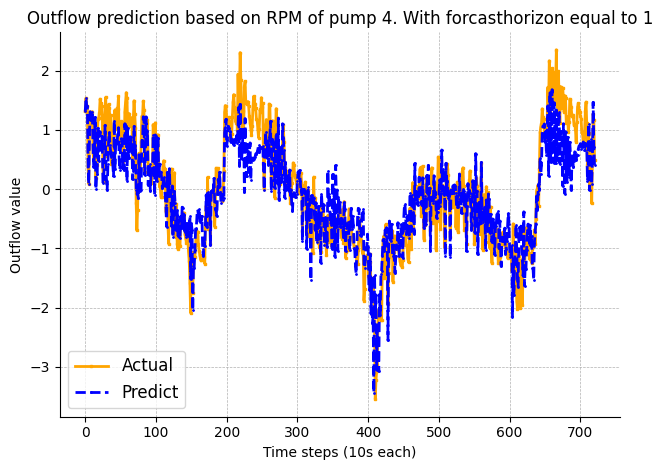

In [41]:


fig, ax = plt.subplots()
ax.plot(y_compare_4, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(yhat ,color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')

ax.set_title(f"Outflow prediction based on RPM of pump 4. With forcasthorizon equal to 1")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()

plt.show()
#plt.savefig()

721


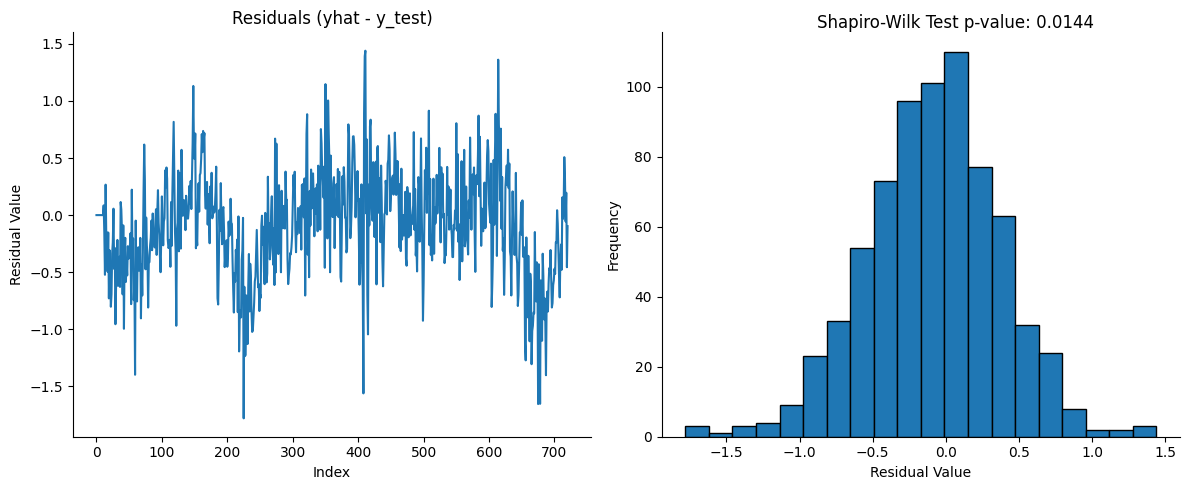

Shapiro-Wilk Test result:
Statistic: 0.9948, p-value: 0.0144


In [42]:
from scipy.stats import shapiro


residuals = yhat - y_compare_4
#print(yhat)
#print(y_test_compare_4)
#print(yhat.squeeze())


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
print(residuals.size)
# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [43]:
alpha = 0.05  # significance level
if p > alpha:
    print("The Shapiro-Wilk test is successful: the data follows a normal distribution.")
else:
    print("The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.")
    

The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.


<built-in method size of Tensor object at 0x7fe334464ad0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33424deb0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33420c110>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334465490>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33420c5f0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334464ad0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33424deb0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33420c110>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334465490>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33420c5f0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe334464ad0>
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fe33424deb0>
<class 'torch.Tensor'>
<built-in method size of Ten

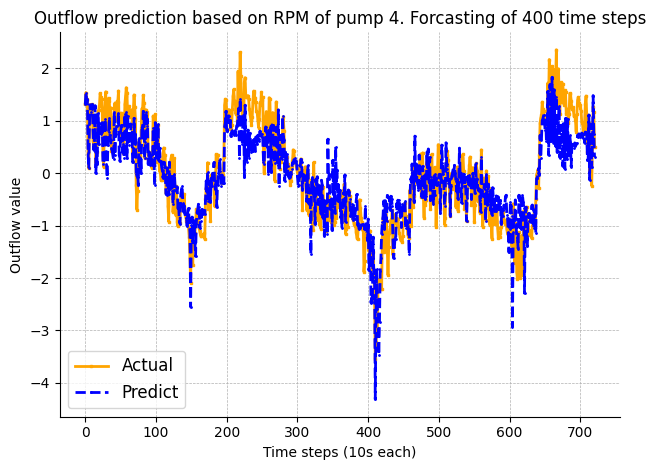

In [44]:
yhat = narx_net.predict(X=x_compare_4, y=y_compare_4, forecast_horizon=400)
# Calculate the error of the model compared to the testing time slot
mse = mean_squared_error(y_compare_4, yhat)
print("MSE: ", mse)
rrse = root_relative_squared_error(y_compare_4, yhat)
print("RRSE: ",rrse)   

fig, ax = plt.subplots()
ax.plot(y_compare_4, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(yhat ,color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')

ax.set_title(f"Outflow prediction based on RPM of pump 4. Forcasting of 400 time steps")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()
# orange_patch = mpatches.Patch(color='orange', label='predicted results')
# blue_patch = mpatches.Patch(color='blue', label='results')
# ax.legend(handles=[blue_patch,orange_patch])

plt.show()

721


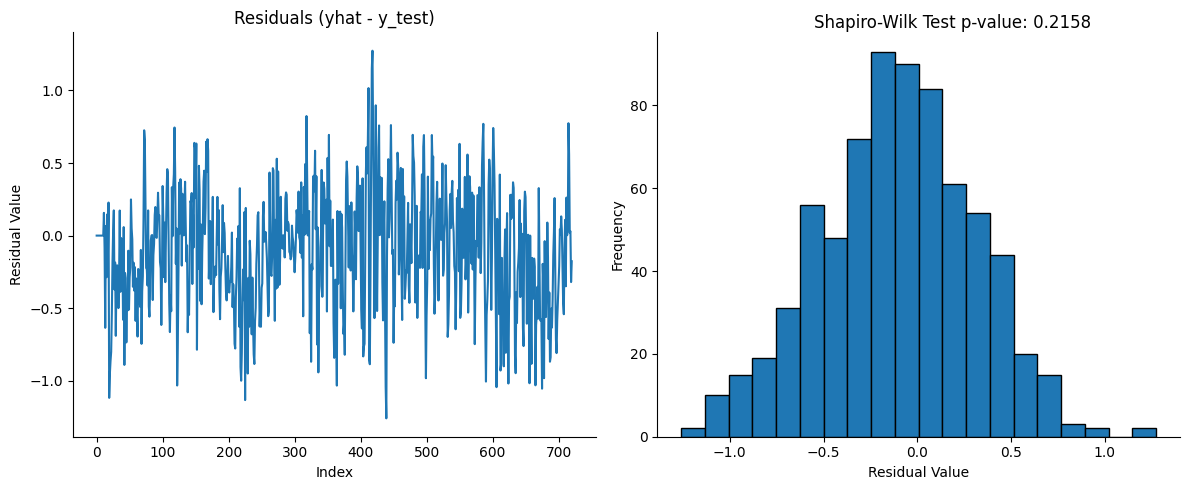

Shapiro-Wilk Test result:
Statistic: 0.9971, p-value: 0.2158


In [ ]:
residuals = yhat - y_compare_4
#print(yhat)
#print(y_test_compare_4)
#print(yhat.squeeze())


# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')
print(residuals.size)
# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [ ]:
alpha = 0.05  # significance level
if p > alpha:
    print("The Shapiro-Wilk test is successful: the data follows a normal distribution.")
else:
    print("The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.")
    

The Shapiro-Wilk test is successful: the data follows a normal distribution.


In [45]:
from sysidentpy.utils.save_load import save_model, load_model
#torch.save(narx_net.net.state_dict(), './best_model.pt')
save_model(model=narx_net, file_name='narx_net_cpu.syspy')

In [ ]:

# Gathering results
r = pd.DataFrame(
    results(
        narx_net.final_model,
        narx_net.theta,
        narx_net.err,
        narx_net.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

AttributeError: 'NARXNN' object has no attribute 'theta'

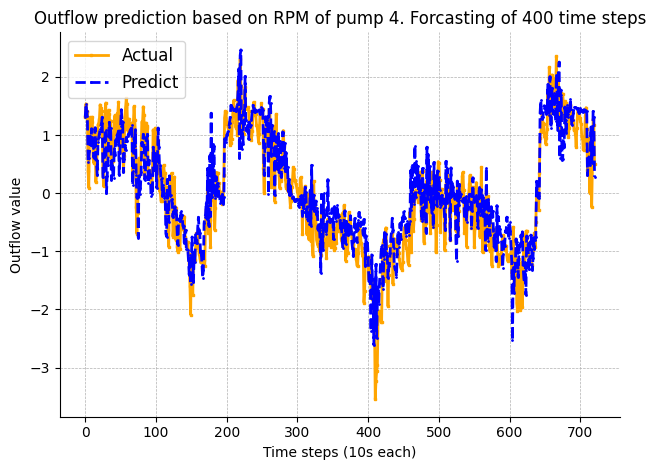

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_compare_4, color='orange', linestyle='-', linewidth=2, marker='s', markersize=1.5, label='Actual')
ax.plot(predict ,color='blue', linestyle='--', linewidth=2, marker='o', markersize=1, label='Predict')

ax.set_title(f"Outflow prediction based on RPM of pump 4. Forcasting of 400 time steps")
ax.set_xlabel(f"Time steps (10s each)")
ax.set_ylabel("Outflow value")
ax.grid(True, which='both', linestyle='--', linewidth = 0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the layout
plt.tight_layout()
# orange_patch = mpatches.Patch(color='orange', label='predicted results')
# blue_patch = mpatches.Patch(color='blue', label='results')
# ax.legend(handles=[blue_patch,orange_patch])

plt.show()